# 1. データの取得  
ダウンロードしたipynbファイルとcsvファイルを自分のGoogleドライブに置く。

## 1-1. csvファイルを利用する場合


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd

df = pd.read_csv('drive/My Drive/RNNによる為替予測/USDJPY_1.csv')
df

,datetime,open,high,low,close,volume
0,2005-05-07T21:00:00.000000000Z,105.145,105.165,105.075,105.125,254
1,2005-05-08T21:00:00.000000000Z,105.135,105.686,105.095,105.628,34018
2,2005-05-09T21:00:00.000000000Z,105.628,105.966,105.390,105.560,34363
3,2005-05-10T21:00:00.000000000Z,105.550,105.946,104.886,105.760,36765
4,2005-05-11T21:00:00.000000000Z,105.760,106.914,105.710,106.776,32469
...,...,...,...,...,...,...
4995,2022-01-26T22:00:00.000000000Z,114.650,115.489,114.476,115.362,85666
4996,2022-01-27T22:00:00.000000000Z,115.358,115.688,115.122,115.238,73707
4997,2022-01-30T22:00:00.000000000Z,115.296,115.592,114.923,115.136,70090
4998,2022-01-31T22:00:00.000000000Z,115.110,115.195,114.566,114.688,68569


# 2. データの加工

In [13]:
import numpy as np

def arrange_df(df, step_num=5): # step_numとは、移動平均で遡るステップサイズ。
  # 指数移動平均
  df['ema'] = df['close'].ewm(span=step_num).mean()
  
  # 変化量
  df['aoc'] = df['close'].diff(1)
  df['aoc'] = df['aoc'].fillna(df['aoc'].median()) # 欠損地を中央値で穴埋め。

  # 指数重み付き移動平均
  ewdf = df['close'].ewm(halflife=step_num).mean()
  vewdf = df['close'].ewm(halflife=step_num).var()
  df['ewdf'] = (df['close'] - ewdf)/(vewdf ** 0.5)
  df['ewdf'] = df['ewdf'].fillna(df['ewdf'].median())
  
  # ヒストリカル・ボラティリティ
  yestaday = df['close'].shift(1)
  today = df['close']
  df['volatility'] = np.log(today/yestaday)
  df['volatility'] = df['volatility'].fillna(df['volatility'].median())
  var = df['volatility'].rolling(250).var() # 日中データの場合は、一年の市場が営業日250日を設定する場合が多い。
  df['volatility'] = abs(var) ** 0.5
  df['volatility'] = df['volatility'].fillna(df['volatility'].median())

  return df

df = arrange_df(df)
df

,datetime,open,high,low,close,volume,ema,aoc,ewdf,volatility
0,2005-05-07T21:00:00.000000000Z,105.145,105.165,105.075,105.125,254,105.125000,0.000,0.057904,0.005169
1,2005-05-08T21:00:00.000000000Z,105.135,105.686,105.095,105.628,34018,105.426800,0.503,0.658172,0.005169
2,2005-05-09T21:00:00.000000000Z,105.628,105.966,105.390,105.560,34363,105.489895,-0.068,0.392623,0.005169
3,2005-05-10T21:00:00.000000000Z,105.550,105.946,104.886,105.760,36765,105.602092,0.200,0.804457,0.005169
4,2005-05-11T21:00:00.000000000Z,105.760,106.914,105.710,106.776,32469,106.052739,1.016,1.416095,0.005169
...,...,...,...,...,...,...,...,...,...,...
4995,2022-01-26T22:00:00.000000000Z,114.650,115.489,114.476,115.362,85666,114.614911,0.681,1.227120,0.003485
4996,2022-01-27T22:00:00.000000000Z,115.358,115.688,115.122,115.238,73707,114.822607,-0.124,0.904714,0.003485
4997,2022-01-30T22:00:00.000000000Z,115.296,115.592,114.923,115.136,70090,114.927071,-0.102,0.674687,0.003476
4998,2022-01-31T22:00:00.000000000Z,115.110,115.195,114.566,114.688,68569,114.847381,-0.448,-0.020913,0.003467


# 3. データを可視化・相関の確認

In [ ]:
data = df['close']

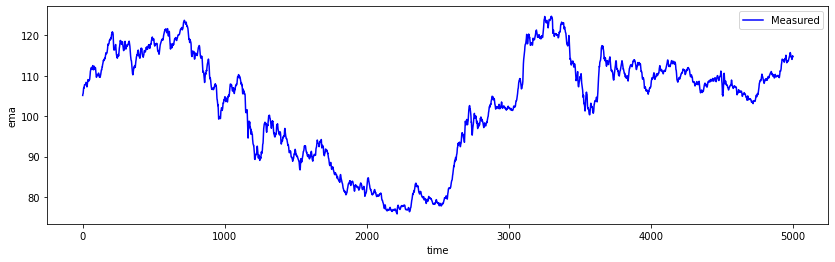

In [5]:
# データの可視化
import matplotlib.pyplot as plt

def show_graph(df, data ,label='close', color="b"):
    X_index = df.index.values
    X = data.values
    plt.figure(figsize=(14, 4))
    plt.xlabel('time')
    plt.ylabel(label)
    plt.plot(X_index, X, color=color, label='Measured')
    plt.legend(loc='upper right')
    plt.show()

show_graph(df, df['ema'], 'ema')

# 4. スケーリング

In [14]:
# 正規化
from sklearn.preprocessing import MinMaxScaler

def Normalization(data):
    data = pd.DataFrame(data)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(data)
    return scaler, data

# 5. 訓練データと検証データとテストデータに分割

In [15]:
def split_train_valid_test(data):
    train, valid, test = data[0:int(len(data)*0.7),:], data[int(len(data)*0.7):int(len(data)*0.9),:], data[int(len(data)*0.9):,:]
    return train, valid, test

# 6. モデルの検証

In [16]:
# モデルのインポート
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow as tf

In [27]:
# ハイパラメータ
window = 50
horizon = 1
epoch_size = 30
batch_size=1
output = 5
units = 20
learning_rate = 0.001
optimizer = 'adam'
activation = 'tanh'
loss = 'mean_squared_error'

In [18]:
# モデルが学習できるようにデータを加工
def create_dataset(dataset, window, output):
    dataX, dataY = [], []
    for i in range(len(dataset)-window-output+1):
        xset, yset = [], []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+window), j]
            xset.append(a)

        b = dataset[(i+window):(i+window)+output]
        yset.append(b)
        dataX.append(xset)
        dataY.append(yset)
    return np.array(dataX), np.array(dataY).reshape(len(dataY),output)

def arrange_dataset(df, datalist, window, horizon, output, scale=True):
    trainlist = []
    validlist = []
    testlist = []
    for i in range(horizon):
      if scale == True:
          scaler, data = Normalization(df[datalist[i]])
      else:
          scaler = 0
          data = df[datalist[i]].to_numpy().reshape(len(df), -1)

      train, valid, test = split_train_valid_test(data)
      trainX, trainY = create_dataset(train, window, output)
      validX, validY = create_dataset(valid, window, output)
      testX, testY = create_dataset(test, window, output)

      trainlist.append(trainX)
      validlist.append(validX)
      testlist.append(testX)

      if i == 0:
        real_trainY = trainY
        real_validY = validY
        real_testY = testY
        real_scaler = scaler        
        real_data = data

    trainX = np.concatenate(trainlist, axis=1)
    validX = np.concatenate(validlist, axis=1)
    testX = np.concatenate(testlist, axis=1)
    return trainX, real_trainY, validX, real_validY, testX, real_testY, real_scaler, real_data

trainX, trainY, validX, validY, testX, testY, scaler, data = arrange_dataset(df, ['ema'], window, horizon, output)

In [28]:
# モデル1
def create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss):
    model = keras.models.Sequential([
        keras.layers.LSTM(units, return_sequences=True, input_shape=(horizon, window)),
        keras.layers.LSTM(units),
        keras.layers.Dense(output, activation=activation)
      ])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
model = create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss)

In [33]:
# モデル2
activation = 'relu'

def create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss):
    model = keras.models.Sequential([
        keras.layers.LSTM(units, return_sequences=True, input_shape=(horizon, window)),
        keras.layers.LSTM(units),
        keras.layers.Dense(output, activation=activation)
      ])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
model = create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss)

In [37]:
# モデル3
units = 60
activation = 'tanh'

def create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss):
    model = keras.models.Sequential([
        keras.layers.LSTM(units, return_sequences=True, input_shape=(horizon, window)),
        keras.layers.LSTM(units),
        keras.layers.Dense(output, activation=activation)
      ])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
model = create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss)

In [41]:
# モデル4
activation = 'sigmoid'

def create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss):
    model = keras.models.Sequential([
        keras.layers.LSTM(units, return_sequences=True, input_shape=(horizon, window)),
        keras.layers.LSTM(units),
        keras.layers.Dense(output, activation=activation)
      ])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
model = create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss)

In [109]:
# モデル5
optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)
activation = 'tanh'

def create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss):
    model = keras.models.Sequential([
        keras.layers.LSTM(units, return_sequences=True, input_shape=(horizon, window)),
        keras.layers.LSTM(units),
        keras.layers.Dense(output, activation=activation)
      ])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
model = create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [124]:
trainX, trainY, validX, validY, testX, testY, scaler, data = arrange_dataset(df, ['ema'], window, horizon, output)

In [125]:
# holizon=1の場合のみ実行。
trainX = trainX.reshape(trainX.shape[0], trainX.shape[2], 1)
trainY = trainY.reshape(trainY.shape[0], trainY.shape[1], 1)
validX = validX.reshape(validX.shape[0], validX.shape[2], 1)
validY = validY.reshape(validY.shape[0], validY.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[2], 1)
testY = testY.reshape(testY.shape[0], testY.shape[1], 1)

In [116]:
# モデル6
optimizer = 'adam'

def create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss):
    model = keras.models.Sequential([
        keras.layers.LSTM(units, return_sequences=True, input_shape=(window, 1)),
        keras.layers.LSTM(units),
        keras.layers.Dense(output, activation=activation)
      ])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
model = create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss)

In [126]:
# モデル7
optimizer = 'adam'

def create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss):
    model = keras.models.Sequential([
        keras.layers.LSTM(units, return_sequences=True, input_shape=(window, 1)),
        keras.layers.LSTM(units, return_sequences=True),
        keras.layers.Dense(output, activation=activation)
      ])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
model = create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss)

In [129]:
# モデル8
def create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss):
    model = keras.models.Sequential([
        keras.layers.LSTM(units, activation=activation, input_shape=(window, 1)),
        keras.layers.RepeatVector(output), 
        keras.layers.LSTM(units, activation=activation, return_sequences=True),
        keras.layers.TimeDistributed(Dense(1))
      ])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
model = create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss)

In [130]:
# モデルの学習
def learning_model(trainX, trainY, validX, validY, model, epoch_size):
  history = model.fit(trainX, trainY, epochs=epoch_size, validation_data=(validX, validY))
  return history

history = learning_model(trainX, trainY, validX, validY, model, epoch_size)

Epoch 1/30
108/108 [==============================] - 4s 14ms/step - loss: 0.0418 - val_loss: 0.0037
Epoch 2/30
108/108 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 3/30
108/108 [==============================] - 1s 8ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 4/30
108/108 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 5/30
108/108 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 6/30
108/108 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/30
108/108 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 8/30
108/108 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/30
108/108 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/30
108/108 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.001

# 7. モデルの性能評価

In [30]:
import math
from sklearn.metrics import mean_squared_error

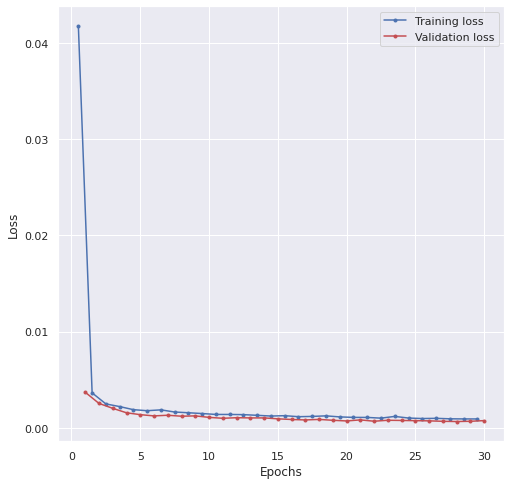

In [131]:
# 各エポック毎の訓練誤差とテスト誤差を可視化。

def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(8, 8))
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

plot_learning_curves(history.history["loss"], history.history["val_loss"])

In [ ]:
# モデル1～5の場合

def pad_array(val, pad_col):
    # 以下のnp.insertは配列pad_colのインデックス0番目の位置にxを挿入するという意味
    return np.array([np.insert(pad_col, 0, x) for x in val])

def reshape_dataset(dataset):
    dataset = dataset.reshape(len(dataset), -1)
    return dataset


def print_mse(model, trainX, trainY, validX, validY, testX, testY, scaler, data, scale=True):
    # 10個前過去のデータ～1個前のデータまでを入力データとし、予測値を求める    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testPredict = model.predict(testX)
    pad_col = np.zeros(data.shape[1]-1)

    # 標準化したデータを元に戻す
    if scale == True:
      trainPredict = scaler.inverse_transform(pad_array(trainPredict, pad_col))
      trainY = scaler.inverse_transform(pad_array(trainY, pad_col))
      validPredict = scaler.inverse_transform(pad_array(validPredict, pad_col))
      validY = scaler.inverse_transform(pad_array(validY, pad_col))
      testPredict = scaler.inverse_transform(pad_array(testPredict, pad_col))
      testY = scaler.inverse_transform(pad_array(testY, pad_col))
    else:
      trainPredict = reshape_dataset(trainPredict)
      trainY = reshape_dataset(trainY)
      validPredict = reshape_dataset(validPredict)
      validY = reshape_dataset(validY)
      testPredict = reshape_dataset(testPredict)
      testY = reshape_dataset(testY)

    trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    validScore = math.sqrt(mean_squared_error(validY[:,0], validPredict[:,0]))
    print('Valid Score: %.2f RMSE' % (validScore))
    testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    return trainPredict, validPredict, testPredict

trainPredict, validPredict, testPredict = print_mse(model, trainX, trainY, validX, validY, testX, testY, scaler, data)

In [136]:
# モデル6の場合

def pad_array(val, pad_col):
    # 以下のnp.insertは配列pad_colのインデックス0番目の位置にxを挿入するという意味
    return np.array([np.insert(pad_col, 0, x) for x in val])

def reshape_dataset(dataset):
    dataset = dataset.reshape(len(dataset), -1)
    return dataset


def print_mse(model, trainX, trainY, validX, validY, testX, testY, scaler, data, scale=True):
    # 10個前過去のデータ～1個前のデータまでを入力データとし、予測値を求める    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testPredict = model.predict(testX)
    pad_col = np.zeros(data.shape[1]-1)
    trainPredict = trainPredict.reshape(trainPredict.shape[0], trainPredict.shape[1])
    validPredict = validPredict.reshape(validPredict.shape[0], validPredict.shape[1])
    testPredict = testPredict.reshape(testPredict.shape[0], testPredict.shape[1])
    trainY = trainY.reshape(trainY.shape[0], trainY.shape[1])
    validY = validY.reshape(validY.shape[0], validY.shape[1])
    testY = testY.reshape(testY.shape[0], testY.shape[1])

    # 標準化したデータを元に戻す
    if scale == True:
      trainPredict = scaler.inverse_transform(trainPredict)
      trainY = scaler.inverse_transform(trainY)
      validPredict = scaler.inverse_transform(validPredict)
      validY = scaler.inverse_transform(validY)
      testPredict = scaler.inverse_transform(testPredict)
      testY = scaler.inverse_transform(testY)
    else:
      trainPredict = reshape_dataset(trainPredict)
      trainY = reshape_dataset(trainY)
      validPredict = reshape_dataset(validPredict)
      validY = reshape_dataset(validY)
      testPredict = reshape_dataset(testPredict)
      testY = reshape_dataset(testY)

    trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    validScore = math.sqrt(mean_squared_error(validY[:,0], validPredict[:,0]))
    print('Valid Score: %.2f RMSE' % (validScore))
    testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    return trainPredict, validPredict, testPredict

trainPredict, validPredict, testPredict = print_mse(model, trainX, trainY, validX, validY, testX, testY, scaler, data)

Train Score: 0.36 RMSE
Valid Score: 0.33 RMSE
Test Score: 0.27 RMSE


In [134]:
# モデル8の場合

def pad_array(val, pad_col):
    # 以下のnp.insertは配列pad_colのインデックス0番目の位置にxを挿入するという意味
    return np.array([np.insert(pad_col, 0, x) for x in val])

def reshape_dataset(dataset):
    dataset = dataset.reshape(len(dataset), -1)
    return dataset


def print_mse(model, trainX, trainY, validX, validY, testX, testY, scaler, data, scale=True):
    # 10個前過去のデータ～1個前のデータまでを入力データとし、予測値を求める    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testPredict = model.predict(testX)
    pad_col = np.zeros(data.shape[1]-1)
    trainPredict = trainPredict.reshape(trainPredict.shape[0], trainPredict.shape[1])
    validPredict = validPredict.reshape(validPredict.shape[0], validPredict.shape[1])
    testPredict = testPredict.reshape(testPredict.shape[0], testPredict.shape[1])
    trainY = trainY.reshape(trainY.shape[0], trainY.shape[1])
    validY = validY.reshape(validY.shape[0], validY.shape[1])
    testY = testY.reshape(testY.shape[0], testY.shape[1])

    # 標準化したデータを元に戻す
    if scale == True:
      trainPredict = scaler.inverse_transform(trainPredict)
      trainY = scaler.inverse_transform(trainY)
      validPredict = scaler.inverse_transform(validPredict)
      validY = scaler.inverse_transform(validY)
      testPredict = scaler.inverse_transform(testPredict)
      testY = scaler.inverse_transform(testY)
    else:
      trainPredict = reshape_dataset(trainPredict)
      trainY = reshape_dataset(trainY)
      validPredict = reshape_dataset(validPredict)
      validY = reshape_dataset(validY)
      testPredict = reshape_dataset(testPredict)
      testY = reshape_dataset(testY)

    trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    validScore = math.sqrt(mean_squared_error(validY[:,0], validPredict[:,0]))
    print('Valid Score: %.2f RMSE' % (validScore))
    testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    return trainPredict, validPredict, testPredict

trainPredict, validPredict, testPredict = print_mse(model, trainX, trainY, validX, validY, testX, testY, scaler, data)